# Part-of-Speech (POS) in NLP

**Part-of-Speech (POS)** tagging is the task of assigning each word (token) in a sentence its grammatical category:  
  - Noun (NOUN), Verb (VERB), Adjective (ADJ), Adverb (ADV), Pronoun (PRON), …  
  - In UD (Universal Dependencies) you often see `UPOS` (universal) vs. `XPOS` (language-specific).  

Why POS tags matter:  
  1. **Syntactic parsing** (constituency/dependency parsers)  
  2. **Named-Entity Recognition** (NER) often uses POS as a feature  
  3. **Chunking** (“shallow parsing”) groups adjacent POS tags into phrases  
  4. **Machine Translation**, **Information Extraction**, **Coreference Resolution**, etc.  

**Type of ML problem**  
  - Sequence labeling / token classification: each token gets one tag  
  - Typically trained & evaluated with accuracy or token-level F1  

Below we’ll:  
  1. Load a UD POS dataset  
  2. Inspect its tags  
  3. Prepare it for fine-tuning a transformer  
  4. (Optional) Wire it up to a `Trainer` with an accuracy metric  

##### importing libraries

In [ ]:
import pyconll
import csv
import pandas as pd
from conllu import parse_incr
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed,  Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
from collections import defaultdict
from collections import Counter
import plotly.express as px
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

##### load Data

In [2]:
data = pyconll.load_from_file('Arabic_POS.conllu')
data

In [3]:
for token in data[0]:
    print(f"{token.form}\t{token.upos}")


برلين	X
ترفض	VERB
حصول	NOUN
شركة	NOUN
اميركية	ADJ
على	ADP
رخصة	NOUN
تصنيع	NOUN
دبابة	NOUN
"	PUNCT
ليوبارد	X
"	PUNCT
الالمانية	ADJ


| POS Category   | POS Tag |
| -------------- | ------- |
| Noun           | NOUN    |
| Verb           | VERB    |
| Adjective      | ADJ     |
| Adverb         | ADV     |
| Pronoun        | PRON    |
| Determiner     | DET     |
| Preposition    | ADP     |
| Conjunction    | CONJ    |
| Proper Noun    | PROPN   |
| Numeral        | NUM     |
| Particle       | PART    |
| Interjection   | INTJ    |
| Auxiliary Verb | AUX     |
| Symbol         | SYM     |
| Punctuation    | PUNCT   |
| Unknown/Other  | X       |


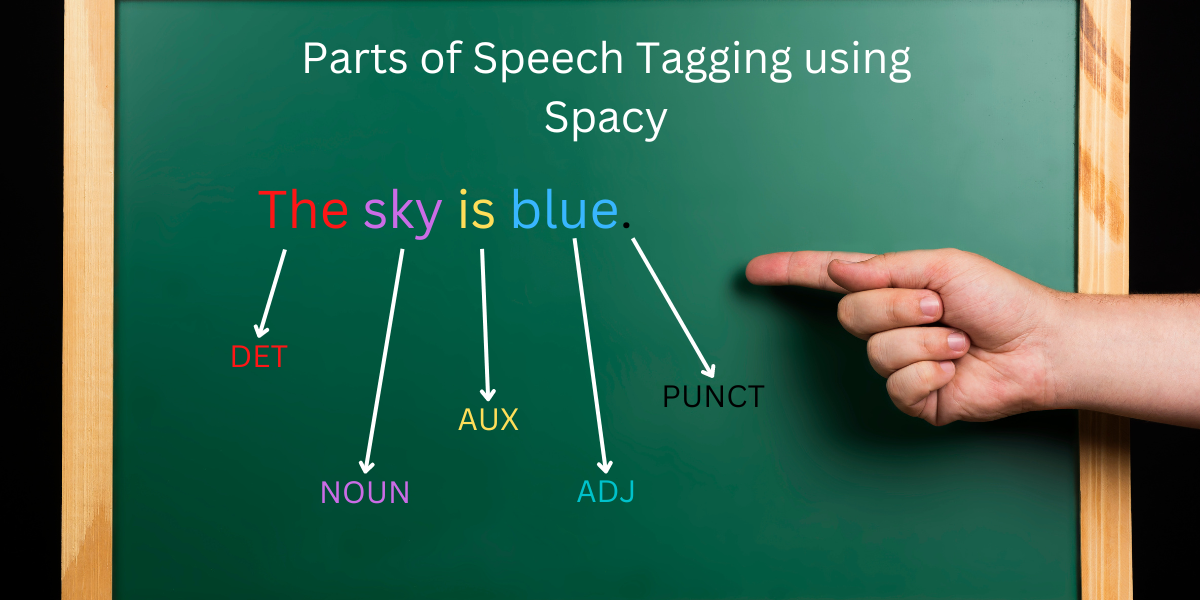

##### count each category

In [ ]:


# Path to your file
file_path = "Arabic_POS.conllu"

# Counter to store POS tags
pos_counter = Counter()

# Open and read the file
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        # Skip empty lines and comments
        if line.strip() == "" or line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if len(parts) > 3:
            pos = parts[3]  # UPOS is the 4th column in CoNLL-U
            pos_counter[pos] += 1

# Display the results
print("POS Tag Counts:")
for tag, count in pos_counter.items():
    print(f"{tag}: {count}")


POS Tag Counts:
X: 13747
VERB: 16789
NOUN: 74546
ADJ: 23498
ADP: 33617
PUNCT: 17511
NUM: 6010
_: 30519
PRON: 8533
SCONJ: 4368
CCONJ: 15803
DET: 4648
PART: 1709
ADV: 880
SYM: 329
AUX: 1699
PROPN: 187
INTJ: 7


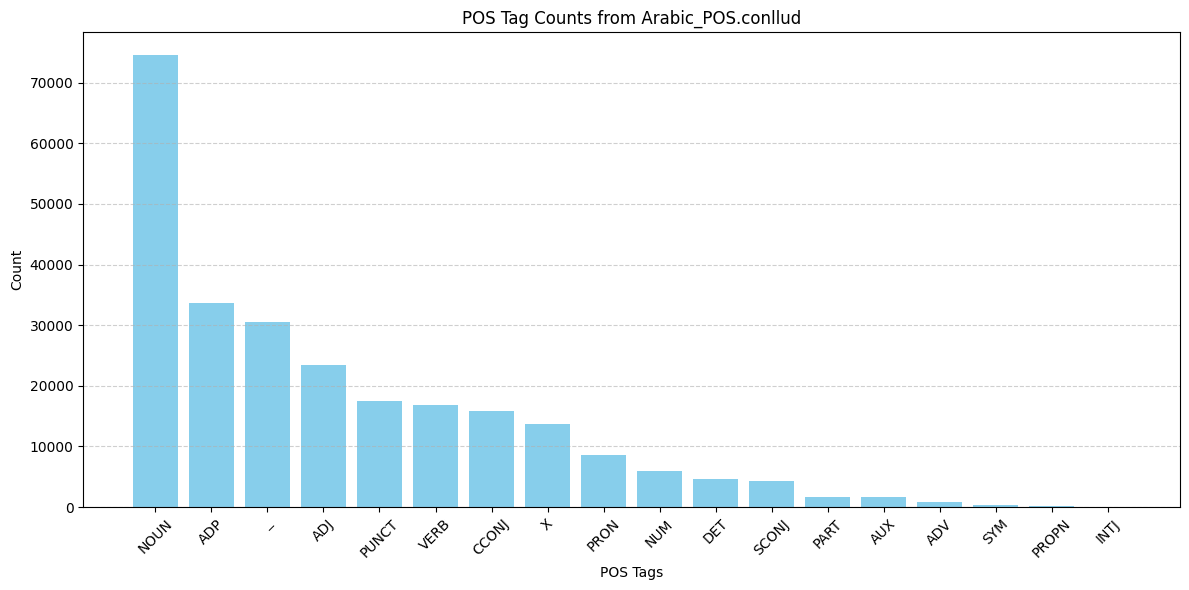

In [ ]:

# POS tag counts (you provided these)
pos_counts = {
    "X": 13747,
    "VERB": 16789,
    "NOUN": 74546,
    "ADJ": 23498,
    "ADP": 33617,
    "PUNCT": 17511,
    "NUM": 6010,
    "_": 30519,
    "PRON": 8533,
    "SCONJ": 4368,
    "CCONJ": 15803,
    "DET": 4648,
    "PART": 1709,
    "ADV": 880,
    "SYM": 329,
    "AUX": 1699,
    "PROPN": 187,
    "INTJ": 7
}

# Sort by count (optional)
sorted_counts = dict(sorted(pos_counts.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')
plt.xlabel("POS Tags")
plt.ylabel("Count")
plt.title("POS Tag Counts from Arabic_POS.conllud")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [ ]:


# Your POS tag counts
pos_counts = {
    "X": 13747,
    "VERB": 16789,
    "NOUN": 74546,
    "ADJ": 23498,
    "ADP": 33617,
    "PUNCT": 17511,
    "NUM": 6010,
    "_": 30519,
    "PRON": 8533,
    "SCONJ": 4368,
    "CCONJ": 15803,
    "DET": 4648,
    "PART": 1709,
    "ADV": 880,
    "SYM": 329,
    "AUX": 1699,
    "PROPN": 187,
    "INTJ": 7
}

# Convert to DataFrame
df_pos = pd.DataFrame(pos_counts.items(), columns=["POS", "Frequency"])

# Create treemap
fig = px.treemap(
    df_pos,
    path=['POS'],
    values='Frequency',
    title='POS Tag Frequency Treemap',
    color='Frequency',
    color_continuous_scale='blues'
)

fig.show()


In [ ]:


# Initialize dictionary to hold one sample per POS
pos_examples = defaultdict(str)

# Read your .conllud file
with open("Arabic_POS.conllu", "r", encoding="utf-8") as f:
    for line in f:
        if line.strip() == "" or line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if len(parts) >= 4:
            word = parts[1]
            pos = parts[3]
            if pos not in pos_examples:
                pos_examples[pos] = word  # store the first example for each POS

# Display
print("POS Tag Examples:")
for pos, word in pos_examples.items():
    print(f"{pos}: {word}")


POS Tag Examples:
X: برلين
VERB: ترفض
NOUN: حصول
ADJ: اميركية
ADP: على
PUNCT: "
NUM: 15
_: عددها
PRON: ها
SCONJ: ان
CCONJ: و
DET: التي
PART: لا
ADV: ايضا
SYM: %
AUX: س
PROPN: النروج
INTJ: مرحبا


##### present random samples of each category

In [ ]:


# Dictionary to hold lists of words for each POS tag
pos_words = defaultdict(list)

# Read your CoNLL-U formatted file
with open("Arabic_POS.conllu", "r", encoding="utf-8") as f:
    for line in f:
        if line.strip() == "" or line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if len(parts) >= 4:
            word = parts[1]
            pos = parts[3]
            pos_words[pos].append(word)

# Now select a random sample from each POS tag
print("🔠 Random Word Samples by POS Tag:\n")
for pos, words in pos_words.items():
    sample = random.choice(words)
    print(f"{pos}: {sample}")


🔠 Random Word Samples by POS Tag:

X: موسكو
VERB: يتم
NOUN: حماية
ADJ: الديموغرافي
ADP: علي
PUNCT: ،
NUM: 90
_: بقيمة
PRON: ها
SCONJ: أن
CCONJ: مما
DET: هذا
PART: لا
ADV: أمس
SYM: /
AUX: كان
PROPN: يومبلغاز
INTJ: ما


##### Replace x with pronoun

In [ ]:


# Read the .conllu file
with open("Arabic_POS.conllu", "r", encoding="utf-8") as f:
    sentences = list(parse_incr(f))

# Replace 'X' POS tag with 'PROPN'
for sentence in sentences:
    for token in sentence:
        if token["upos"] == "X":
            token["upos"] = "PROPN"

# Optional: Save the modified data back to a new .conllu file
with open("Arabic_POS_fixed.conllu", "w", encoding="utf-8") as f:
    for sentence in sentences:
        f.write(sentence.serialize())


In [ ]:


# Path to your file
file_path = "Arabic_POS_fixed.conllu"

# Counter to store POS tags
pos_counter = Counter()

# Open and read the file
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        # Skip empty lines and comments
        if line.strip() == "" or line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if len(parts) > 3:
            pos = parts[3]  # UPOS is the 4th column in CoNLL-U
            pos_counter[pos] += 1

# Display the results
print("POS Tag Counts:")
for tag, count in pos_counter.items():
    print(f"{tag}: {count}")


POS Tag Counts:
PROPN: 13934
VERB: 16789
NOUN: 74546
ADJ: 23498
ADP: 33617
PUNCT: 17511
NUM: 6010
_: 30519
PRON: 8533
SCONJ: 4368
CCONJ: 15803
DET: 4648
PART: 1709
ADV: 880
SYM: 329
AUX: 1699
INTJ: 7


##### lemattization using built in function

In [32]:
def categorize_arabic_word_simple(word):
    """
    Categorize complex Arabic words using simple rule-based approach
    
    Args:
        word: An Arabic word string like بالنسبة
        
    Returns:
        A dictionary with the original word, its potential segments, and rough category
    """
    # Define common prefixes
    prefixes = {
        'ب': 'PREP',  # bi (with/by)
        'ل': 'PREP',  # li (for/to)
        'ك': 'PREP',  # ka (like/as)
        'و': 'CONJ',  # wa (and)
        'ف': 'CONJ',  # fa (so/then)
        'ال': 'DET',  # al (the)
        'لل': 'PREP+DET',  # li+al (for the)
        'بال': 'PREP+DET',  # bi+al (with the)
        'وال': 'CONJ+DET',  # wa+al (and the)
        'فال': 'CONJ+DET',  # fa+al (so the)
        'أ': 'PART',  # interrogative particle
        'س': 'PART',  # future marker
        'است': 'VERB_PREFIX'  # causative/reflexive verb form
    }
    
    # Define common suffixes
    suffixes = {
        'ه': 'PRON',  # hu (his/him/it)
        'ها': 'PRON',  # ha (her/it)
        'هم': 'PRON',  # hum (their/them)
        'ي': 'PRON',  # i/y (my/me)
        'ك': 'PRON',  # ka (your-masc)
        'كِ': 'PRON',  # ki (your-fem)
        'نا': 'PRON',  # na (our/us)
        'ون': 'NOUN_SUFFIX',  # un (masculine plural)
        'ات': 'NOUN_SUFFIX',  # at (feminine plural)
        'ين': 'NOUN_SUFFIX',  # in (masculine plural/dual)
        'ان': 'NOUN_SUFFIX',  # an (dual)
        'ة': 'NOUN_SUFFIX'  # ta marbouta (feminine marker)
    }
    
    segments = []
    pos_tags = []
    word_type = "UNKNOWN"
    
    # Check for prefixes
    found_prefix = False
    for prefix, pos in sorted(prefixes.items(), key=lambda x: len(x[0]), reverse=True):
        if word.startswith(prefix) and len(word) > len(prefix):
            segments.append(prefix)
            pos_tags.append(pos)
            remaining = word[len(prefix):]
            segments.append(remaining)
            found_prefix = True
            break
    
    # If no prefix was found, add the whole word
    if not found_prefix:
        segments.append(word)
    
    # Check for suffixes in the last segment
    last_segment = segments[-1]
    for suffix, pos in sorted(suffixes.items(), key=lambda x: len(x[0]), reverse=True):
        if last_segment.endswith(suffix) and len(last_segment) > len(suffix):
            stem = last_segment[:-len(suffix)]
            segments[-1] = stem
            segments.append(suffix)
            pos_tags.append("STEM")
            pos_tags.append(pos)
            break
    
    # If no POS tags were assigned yet (no suffixes found)
    if len(pos_tags) < len(segments):
        # Try to determine the word type based on patterns
        last_segment = segments[-1]
        
        # Some basic word categorization rules
        if word.startswith('ب') or word.startswith('ل') or word.startswith('ك'):
            word_type = "PREP_PHRASE"
        elif word.startswith('و') or word.startswith('ف'):
            word_type = "CONJ_PHRASE"
        elif 'أن' in word or word.startswith('أن'):
            word_type = "COMPLEMENTIZER"
        elif 'ال' in word:
            word_type = "DEF_NOUN"
        else:
            word_type = "NOUN"  # Default assumption
        
        # Fill in missing POS tags
        while len(pos_tags) < len(segments):
            pos_tags.append("STEM")
    
    return {
        "word": word,
        "segments": segments,
        "pos_tags": pos_tags,
        "word_type": word_type
    }

# Example usage
example_words = ["بالنسبة", "أنه", "بقيمة"]
for word in example_words:
    result = categorize_arabic_word_simple(word)
    print(f"Word: {result['word']}")
    print(f"Segments: {result['segments']}")
    print(f"POS tags: {result['pos_tags']}")
    print(f"Word type: {result['word_type']}")
    print()

Word: بالنسبة
Segments: ['بال', 'نسب', 'ة']
POS tags: ['PREP+DET', 'STEM', 'NOUN_SUFFIX']
Word type: UNKNOWN

Word: أنه
Segments: ['أ', 'ن', 'ه']
POS tags: ['PART', 'STEM', 'PRON']
Word type: UNKNOWN

Word: بقيمة
Segments: ['ب', 'قيم', 'ة']
POS tags: ['PREP', 'STEM', 'NOUN_SUFFIX']
Word type: UNKNOWN



In [36]:
input_path = "Arabic_POS_fixed.conllu"
output_path = "Arabic_POS_updated.conllu"

with open(input_path, "r", encoding="utf-8") as f:
    sentences = list(parse_incr(f))

# Step 3: Replace upos '_' using the custom categorizer
for sentence in sentences:
    for token in sentence:
        if token["upos"] == "_":
            analyzed = categorize_arabic_word_simple(token["form"])  # Use the actual word
            # Use the last tag (most specific), or any logic you prefer
            token["upos"] = analyzed["pos_tags"][-1] if analyzed["pos_tags"] else "STEM"

# Step 4: Save the updated data to a new .conllu file
with open(output_path, "w", encoding="utf-8") as f:
    for sentence in sentences:
        f.write(sentence.serialize())

In [ ]:


# Path to your file
file_path = "Arabic_POS_updated.conllu"

# Counter to store POS tags
pos_counter = Counter()

# Open and read the file
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        # Skip empty lines and comments
        if line.strip() == "" or line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if len(parts) > 3:
            pos = parts[3]  # UPOS is the 4th column in CoNLL-U
            pos_counter[pos] += 1

# Display the results
print("POS Tag Counts:")
for tag, count in pos_counter.items():
    print(f"{tag}: {count}")


POS Tag Counts:
PROPN: 13934
VERB: 16789
NOUN: 74546
ADJ: 23498
ADP: 33617
PUNCT: 17511
NUM: 6010
PRON: 17169
SCONJ: 4368
STEM: 15944
NOUN_SUFFIX: 5939
CCONJ: 15803
DET: 4648
PART: 1709
ADV: 880
SYM: 329
AUX: 1699
INTJ: 7


In [38]:
data_ = pyconll.load_from_file('Arabic_POS_updated.conllu')
data_

In [39]:
# Prepare the dataset
sentences = []
labels = []

for sentence in data_:
    words = []
    tags = []
    for token in sentence:
        if token.upos:
            words.append(token.form)
            tags.append(token.upos)
    if words:
        sentences.append(words)
        labels.append(tags)


In [40]:
print(sentences[0])
print(labels[0])

['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
['PROPN', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ']


In [ ]:

# Read and parse correctly
with open("Arabic_POS_updated.conllu", "r", encoding="utf-8") as f:
    sentences = list(parse_incr(f))  # Ensures we have proper sentence objects

# Safely extract all words and tags
all_words = set()
all_tags = set()

for sentence in sentences:
    for token in sentence:
        if isinstance(token, dict):  # make sure it's a real token
            all_words.add(token.get("form", ""))
            all_tags.add(token.get("upos", ""))

# Build mappings
word2idx = {w: i + 1 for i, w in enumerate(sorted(all_words))}  # +1 for padding
tag2idx = {t: i for i, t in enumerate(sorted(all_tags))}


In [45]:
print(len(word2idx))
print(len(tag2idx))

33496
18


##### USING BILSTM

In [ ]:


# Prepare data sequences
X = []  # word index sequences
y = []  # tag index sequences

for sentence in sentences:
    word_ids = []
    tag_ids = []
    for token in sentence:
        if isinstance(token, dict):
            word = token.get("form", "")
            tag = token.get("upos", "")

            word_ids.append(word2idx.get(word, word2idx.get("UNK", 0)))
            tag_ids.append(tag2idx.get(tag, -1))  # -1 or tag2idx["PAD"]

    X.append(word_ids)
    y.append(tag_ids)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [ ]:


max_len = max(len(seq) for seq in X)  # or choose a fixed max length

X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post')
y_train_padded = pad_sequences(y_train, maxlen=max_len, padding='post')
y_test_padded = pad_sequences(y_test, maxlen=max_len, padding='post')


In [50]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=50000, output_dim=50, input_length=max_len)(input_word)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(18, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

c:\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 478)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 478, 50)        │     2,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 478, 200)       │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 478, 18)        │         3,618 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,624,418 (10.01 MB)

 Trainable params: 2,624,418 (10.01 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [58]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3,  restore_best_weights=True)

callbacks = [early_stopping]

history = model.fit(
    x=X_train_padded,
    y=y_train_padded,
    validation_data=(X_test_padded,y_test_padded),
    batch_size=32, 
    epochs=8,
    callbacks=callbacks)


Epoch 1/8
 13/162 ━━━━━━━━━━━━━━━━━━━━ 24:33 10s/step - accuracy: 0.6995 - loss: 1.6169

KeyboardInterrupt: 

##### evaluation

In [ ]:



plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_pred=model.predict(X_test_padded)

In [ ]:
print(confusion_matrix(y_test_padded, y_pred))
print("\n")
print(classification_report(y_test_padded, y_pred))

In [ ]:
from sklearn.metrics import f1_score

# Assume y_true are the true labels and y_pred are the predicted labels
f1_macro = f1_score(X_test_padded, y_pred, average='macro')
print(f"Macro F1 Score: {f1_macro}")